In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from environment import run_experiment, RunParameters, RunStatistics
from baifg.model.feedback_graph import FeedbackGraph
from baifg.model.reward_model import GaussianRewardModel, RewardType
from baifg.algorithms.eps_greedy import EpsilonGreedy, EpsilonGreedyParameters
from baifg.algorithms.ucb import UCB
from baifg.algorithms.exp3g import Exp3G, Exp3GParameters
from baifg.algorithms.tas_fg import TaSFG, TaSFGParameters
from baifg.algorithms.base.graph_estimator import GraphEstimator
from baifg.algorithms.base.base_algorithm import BaseAlg
from baifg.utils.graphs import make_loopless_clique, make_loopystar_graph
from itertools import product
from typing import List, NamedTuple
from tqdm import tqdm

def make_model(algo_name: BaseAlg, algo_params: NamedTuple, K: int, fg: FeedbackGraph, delta: float, informed: bool) -> BaseAlg:
    if algo_name == EpsilonGreedy:
        return EpsilonGreedy(
            GraphEstimator.optimistic_graph(K, informed=informed, known=False),
            fg.reward_model.reward_type,
            delta=delta,
            parameters=algo_params)
    elif algo_name == UCB:
        return UCB(
            GraphEstimator.optimistic_graph(K, informed=informed, known=False),
            reward_type=fg.reward_model.reward_type,
            delta=delta)
    elif algo_name == Exp3G:
        return Exp3G(
            GraphEstimator.optimistic_graph(K, informed=informed, known=False),
            reward_type=fg.reward_model.reward_type,
            delta=delta,
            parameters=algo_params
        )
    elif algo_name == TaSFG:
        return TaSFG(
            GraphEstimator.optimistic_graph(K, informed=informed, known=False),
            reward_type=fg.reward_model.reward_type,
            delta=delta, parameters=TaSFGParameters(update_frequency=2 * K)
        )
    raise Exception('Algorithm not found')



In [2]:
envs: List[RunParameters] = []
Kvalues = [5,7,10]
delta = np.exp(-np.linspace(1,6,4))

for K, delta, informed in product(Kvalues, delta, [False]):
    envs.append(
        RunParameters('Loopless clique', f'p=0.5, K={K}, delta={delta}, informed={informed}', delta, informed=True,
                      known=False, fg=make_loopless_clique(p=0.5, mu=np.linspace(0, 1, K)),
                      results = {})
    )
    envs.append(
        RunParameters('Loopystar', f'p=0.2, q=0.25, r=0.25 K={K}, delta={delta}, informed={informed}', delta, informed=True,
                      known=False, fg=make_loopystar_graph(p=0.2, q=0.25, r=0.25, K=K),
                      results = {})
    )

algorithms = [
    (EpsilonGreedy, EpsilonGreedyParameters(exp_rate=0.25, information_greedy=False)),
    (EpsilonGreedy, EpsilonGreedyParameters(exp_rate=0.25, information_greedy=True)),
    (Exp3G, Exp3GParameters(exp_rate=0.25, learn_rate=0.1)),
    (TaSFG, TaSFGParameters(update_frequency=10)),
    (UCB, None)
]

In [3]:

Nsims = 5

df = pd.DataFrame({},  columns =  ["env", "K", "seed", "algorithm", "delta", "stopping_time", "identified_optimal_arm"])

for env in envs:
    print(f'Running {env.name} - {env.description}')
    for n in tqdm(range(Nsims)):
        for algo, algo_params in algorithms:
            algo = make_model(algo_name=algo, algo_params=algo_params,
                              K=env.fg.K, fg=env.fg, delta=env.delta, informed=env.informed)
            results = run_experiment(fg=env.fg, algo=algo, seed=n)

            if algo.NAME not in env.results:
                env.results[algo.NAME] = []
            env.results[algo.NAME].append(results)

            df.loc[len(df.index)] = [
                env.name, env.fg.K, n, algo.NAME, env.delta, results.stopping_time, 
                results.estimated_best_vertex == env.fg.reward_model.astar]


Running Loopless clique - p=0.5, K=5, delta=0.36787944117144233, informed=False


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=5, delta=0.36787944117144233, informed=False


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Running Loopless clique - p=0.5, K=5, delta=0.06948345122280151, informed=False


100%|██████████| 5/5 [00:27<00:00,  5.51s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=5, delta=0.06948345122280151, informed=False


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


Running Loopless clique - p=0.5, K=5, delta=0.013123728736940956, informed=False


100%|██████████| 5/5 [00:39<00:00,  7.80s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=5, delta=0.013123728736940956, informed=False


100%|██████████| 5/5 [00:40<00:00,  8.19s/it]


Running Loopless clique - p=0.5, K=5, delta=0.0024787521766663585, informed=False


100%|██████████| 5/5 [01:04<00:00, 12.94s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=5, delta=0.0024787521766663585, informed=False


100%|██████████| 5/5 [01:26<00:00, 17.31s/it]


Running Loopless clique - p=0.5, K=7, delta=0.36787944117144233, informed=False


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=7, delta=0.36787944117144233, informed=False


100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


Running Loopless clique - p=0.5, K=7, delta=0.06948345122280151, informed=False


100%|██████████| 5/5 [00:43<00:00,  8.67s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=7, delta=0.06948345122280151, informed=False


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


Running Loopless clique - p=0.5, K=7, delta=0.013123728736940956, informed=False


100%|██████████| 5/5 [01:19<00:00, 15.91s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=7, delta=0.013123728736940956, informed=False


100%|██████████| 5/5 [01:28<00:00, 17.74s/it]


Running Loopless clique - p=0.5, K=7, delta=0.0024787521766663585, informed=False


100%|██████████| 5/5 [02:06<00:00, 25.33s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=7, delta=0.0024787521766663585, informed=False


100%|██████████| 5/5 [01:25<00:00, 17.06s/it]


Running Loopless clique - p=0.5, K=10, delta=0.36787944117144233, informed=False


100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=10, delta=0.36787944117144233, informed=False


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


Running Loopless clique - p=0.5, K=10, delta=0.06948345122280151, informed=False


100%|██████████| 5/5 [01:21<00:00, 16.22s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=10, delta=0.06948345122280151, informed=False


100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Running Loopless clique - p=0.5, K=10, delta=0.013123728736940956, informed=False


100%|██████████| 5/5 [02:29<00:00, 29.96s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=10, delta=0.013123728736940956, informed=False


100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


Running Loopless clique - p=0.5, K=10, delta=0.0024787521766663585, informed=False


100%|██████████| 5/5 [03:14<00:00, 38.90s/it]


Running Loopystar - p=0.2, q=0.25, r=0.25 K=10, delta=0.0024787521766663585, informed=False


100%|██████████| 5/5 [01:02<00:00, 12.58s/it]


C:\Users\russo\AppData\Local\Temp\ipykernel_14300\1743795343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(3)


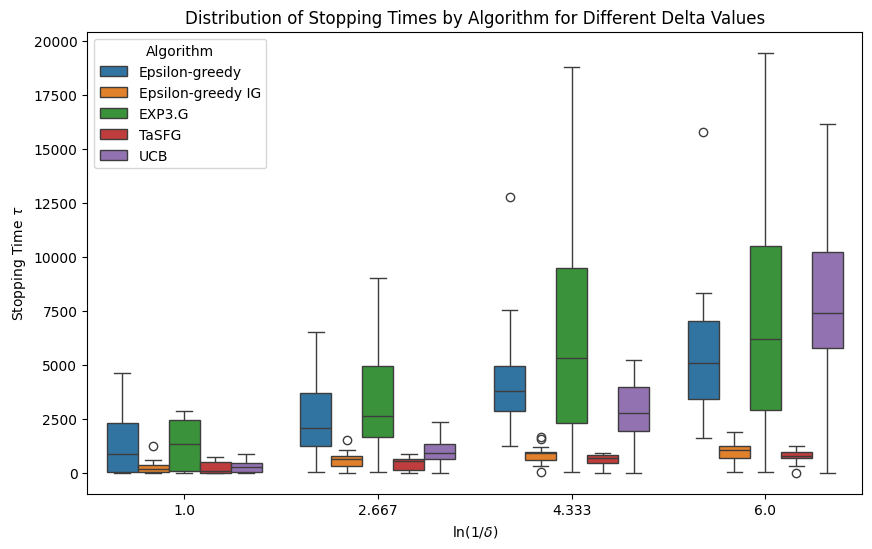

In [4]:


# Filter the DataFrame for a given environment, e.g., "Loopless clique"
filtered_df = df[df['env'] == 'Loopystar']
filtered_df['delta'] = np.log(1/filtered_df['delta']).round(3)
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df)

# Customize labels
plt.xlabel(r'$\ln(1/\delta)$')
plt.ylabel(r'Stopping Time $\tau$')
plt.title('Distribution of Stopping Times by Algorithm for Different Delta Values')
plt.legend(title='Algorithm')
#plt.gca().invert_xaxis()

# Display the plot
plt.show()

C:\Users\russo\AppData\Local\Temp\ipykernel_14300\599889599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(3)


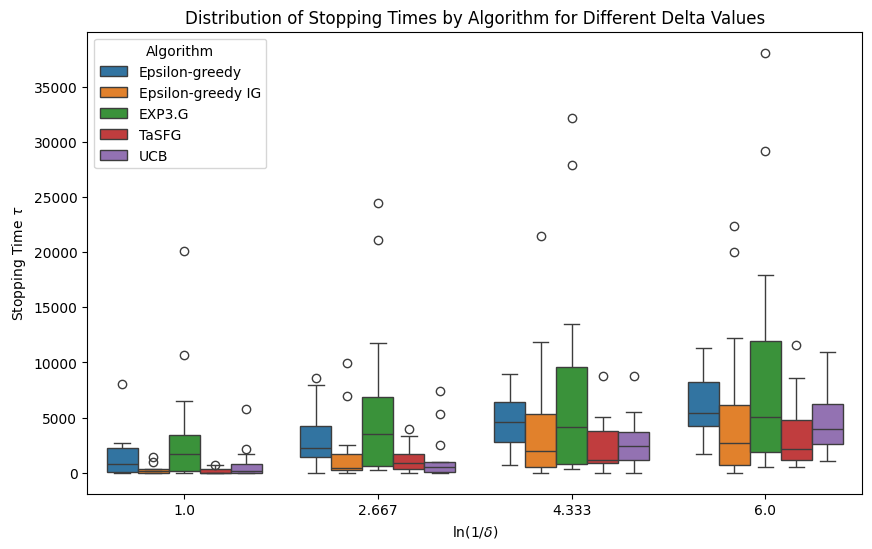

In [5]:


# Filter the DataFrame for a given environment, e.g., "Loopless clique"
filtered_df = df[df['env'] == 'Loopless clique']
filtered_df['delta'] = np.log(1/filtered_df['delta']).round(3)
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df)

# Customize labels
plt.xlabel(r'$\ln(1/\delta)$')
plt.ylabel(r'Stopping Time $\tau$')
plt.title('Distribution of Stopping Times by Algorithm for Different Delta Values')
plt.legend(title='Algorithm')
#plt.gca().invert_xaxis()

# Display the plot
plt.show()

In [6]:
df

,env,K,seed,algorithm,delta,stopping_time,identified_optimal_arm
0,Loopless clique,5,0,Epsilon-greedy,0.367879,378,True
1,Loopless clique,5,0,Epsilon-greedy IG,0.367879,190,True
2,Loopless clique,5,0,EXP3.G,0.367879,2537,True
3,Loopless clique,5,0,TaSFG,0.367879,566,True
4,Loopless clique,5,0,UCB,0.367879,6,False
...,...,...,...,...,...,...,...
595,Loopystar,10,4,Epsilon-greedy,0.002479,5987,True
596,Loopystar,10,4,Epsilon-greedy IG,0.002479,677,True
597,Loopystar,10,4,EXP3.G,0.002479,7849,True
598,Loopystar,10,4,TaSFG,0.002479,649,True


In [7]:
df

,env,K,seed,algorithm,delta,stopping_time,identified_optimal_arm
0,Loopless clique,5,0,Epsilon-greedy,0.367879,378,True
1,Loopless clique,5,0,Epsilon-greedy IG,0.367879,190,True
2,Loopless clique,5,0,EXP3.G,0.367879,2537,True
3,Loopless clique,5,0,TaSFG,0.367879,566,True
4,Loopless clique,5,0,UCB,0.367879,6,False
...,...,...,...,...,...,...,...
595,Loopystar,10,4,Epsilon-greedy,0.002479,5987,True
596,Loopystar,10,4,Epsilon-greedy IG,0.002479,677,True
597,Loopystar,10,4,EXP3.G,0.002479,7849,True
598,Loopystar,10,4,TaSFG,0.002479,649,True
